In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, callbacks

2024-03-21 20:35:55.750657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 20:35:55.750814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 20:35:55.845472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 20:35:56.033939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 20:35:57.823020: W tensorflow/compiler/tf2

In [2]:
MODEL_NAME = "./treino/primeiro_treino"
PASTA_FOURIER = "data/fourier/"
SPS = 200

In [3]:
df = pd.read_csv('data/scores.csv')

In [4]:
df = df.sample(frac=1, random_state=200)

In [5]:
df_val = df.head(2700)
df_train = df.tail( df.shape[0]- 2700 )

In [6]:
def get_data(eeg):
    return np.load(PASTA_FOURIER+str(eeg)+".npy")


def get_start_end(row, pos, max_size):
    if pos == len(row['janelas']):
        return max_size, max_size

    j = row['janelas'].split(',')[0].split('-')
    return float(j[0])*2, float(j[1])*2

def score_data(row):
    data = get_data(row['eeg_id'])
    max_size = data.shape[0]
    scores = [] 
    j_pos = 0
    start, end = get_start_end(row, j_pos, max_size)

    for i in range(max_size):
        if end < i:
            j_pos += 1
            start, end = get_start_end(row, j_pos, max_size)

        if i >= start and i <= end:
            scores.append( [row['seizure_vote'],row['lpd_vote'],row['gpd_vote'],row['lrda_vote'],row['grda_vote'],row['other_vote'] ] )
        else:
            scores.append( [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] )


    return data, scores


In [7]:
def get_scored_train_data():
    for i, row in df_train.iterrows():
        yield( score_data(row) )

def get_scored_val_data():
    for i, row in df_val.iterrows():
        yield( score_data(row) )


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(2, (2, 2), activation='relu', input_shape=(20, 200, 1)))
model.add(layers.MaxPooling2D((2, 20)))
model.add(layers.Conv2D(4, (2, 2), activation='relu', input_shape=(20, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))


2024-03-21 20:35:59.692150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 20:35:59.995246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 20:35:59.996441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
model=tf.keras.models.load_model(MODEL_NAME)

In [10]:
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 19, 199, 2)        10        
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 9, 9, 2)           0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 8, 8, 4)           36        
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 4, 4, 4)           0         
 ng2D)                                                           
                                                                 
 flatten_41 (Flatten)        (None, 64)                0         
                                                                 
 dense_83 (Dense)            (None, 200)             

In [12]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy()
)

In [13]:
train_data = tf.data.Dataset.from_generator(
        get_scored_train_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200), dtype=tf.float16),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float16)
        )
    )

val_data = tf.data.Dataset.from_generator(
        get_scored_val_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200), dtype=tf.float16),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float16)
        )
    )

In [14]:

history = model.fit(
    train_data,
    epochs=20,
    batch_size=100,
    shuffle=True,
    validation_data = val_data,
    verbose= 1,
    callbacks = [
        callbacks.EarlyStopping(monitor="val_loss", patience=2),
        callbacks.ModelCheckpoint(MODEL_NAME, save_best_only = True)
    ]
)

Epoch 1/20


2024-03-21 20:37:17.765222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-21 20:37:17.940628: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 20:37:17.954188: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 20:37:20.510243: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa198ce8e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 20:37:20.510278: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro M1000M, Compute Capability 5.0
2024-03-21 20:37:20.527871: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711049840.709481    6577 device_compiler.h:186] Com

    802/Unknown - 132s 157ms/step - loss: 2.4299

/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py:229: RuntimeWarning: overflow encountered in cast
  result = np.asarray(value, dtype=dtype, order="C")


  17060/Unknown - 597s 35ms/step - loss: 2.3866

2024-03-21 20:48:27.309364: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4707666916553450623
2024-03-21 20:48:27.309408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14281794889673714745


INFO:tensorflow:Assets written to: ./treino/primeiro_treino/assets


INFO:tensorflow:Assets written to: ./treino/primeiro_treino/assets


17063/17063 [==============================] - 672s 39ms/step - loss: 2.3864 - val_loss: 2.3758
Epoch 2/20
  810/17063 [>.............................] - ETA: 6:57 - loss: 2.3609

/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py:229: RuntimeWarning: overflow encountered in cast
  result = np.asarray(value, dtype=dtype, order="C")


17063/17063 [==============================] - 502s 29ms/step - loss: 2.3864 - val_loss: 2.3758
Epoch 3/20
 2556/17063 [===>..........................] - ETA: 6:24 - loss: 2.3845

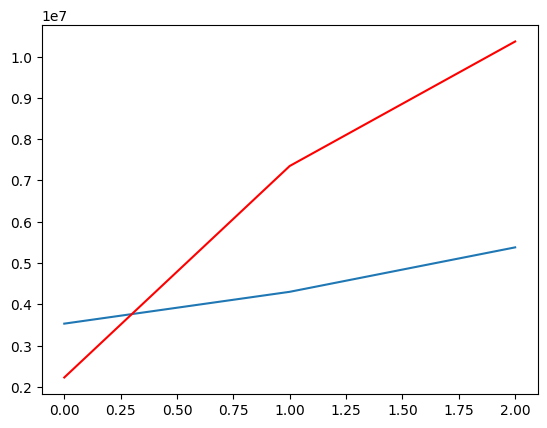

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')